# Diabetic Retinopathy Detection

This notebook implements a machine learning model for diabetic retinopathy detection using balanced sampling with data augmentation.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
import random
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Check TensorFlow/Keras version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.17.0
Keras version: 3.4.1


## Step 1: Data Exploration

Step 1: Data Exploration
Classes in the dataset: ['Mild', 'Moderate', 'No DR', 'Proliferative DR', 'Severe']
Number of images per class:
Mild: 2443 images
Moderate: 5292 images
No DR: 25810 images
Proliferative DR: 708 images
Severe: 873 images


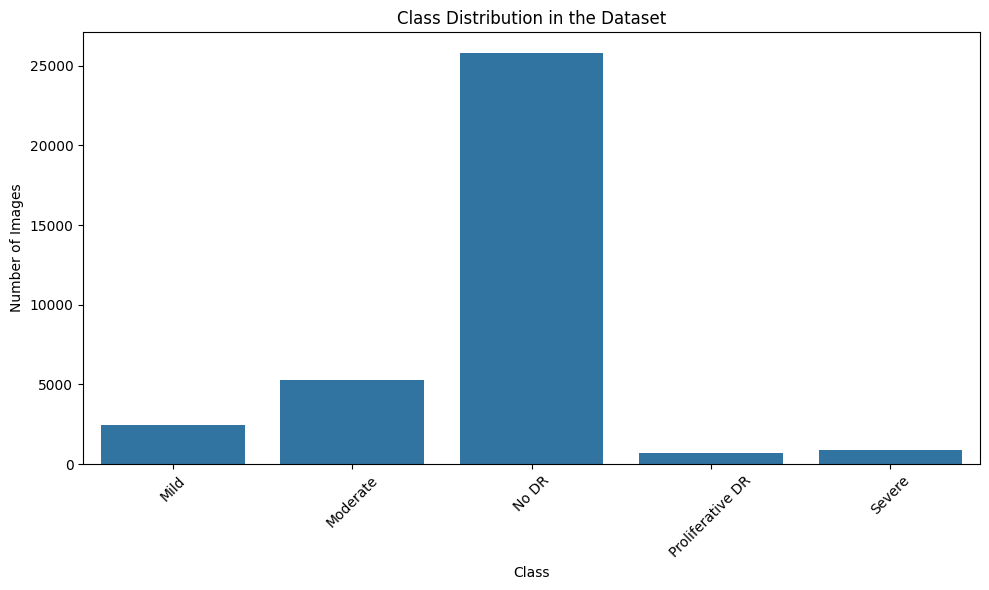

In [2]:
print("Step 1: Data Exploration")

# Define the dataset path
dataset_path = 'dataset/'

# List all classes/folders in the dataset
classes = os.listdir(dataset_path)
classes = [cls for cls in classes if os.path.isdir(os.path.join(dataset_path, cls))]
print(f"Classes in the dataset: {classes}")

# Count number of images in each class
class_counts = {}
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_path))
    class_counts[cls] = num_images

print("Number of images per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 2: Balanced Data Sampling with Augmentation

We'll create a balanced dataset with 2000 images per class. For classes with fewer images, we'll use data augmentation to generate additional images.

In [3]:
print("\nStep 2: Balanced Data Sampling with Augmentation (2000 images per class)")

# Define the target number of images per class
TARGET_IMAGES_PER_CLASS = 2000

# Define image dimensions
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3


Step 2: Balanced Data Sampling with Augmentation (2000 images per class)


In [4]:
# Function to generate augmented images for classes with fewer than target images
def augment_class(class_path, original_files, target_count):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    num_original = len(original_files)
    num_to_generate = target_count - num_original
    
    print(f"  Class has {num_original} images, generating {num_to_generate} augmented images")
    
    augmented_images = []
    for img_file in tqdm(original_files, desc="Loading original images"):
        try:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            augmented_images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    if num_to_generate > 0:
        original_images = []
        for img_file in random.sample(original_files, min(100, len(original_files))):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            original_images.append(img)
        
        original_images = np.array(original_images)
        
        augmentation_count = 0
        for batch in tqdm(datagen.flow(original_images, batch_size=32), 
                           desc="Generating augmented images", 
                           total=num_to_generate//32 + 1):
            augmented_images.extend(batch)
            augmentation_count += len(batch)
            if augmentation_count >= num_to_generate:
                break
        
        augmented_images = augmented_images[:target_count]
    
    return augmented_images

Class Mild: Sampled 2000 from 2443 original images
Class Moderate: Sampled 2000 from 5292 original images
Class No DR: Sampled 2000 from 25810 original images
Class Proliferative DR: Using all 708 original images + will generate 1292 augmented images
Class Severe: Using all 873 original images + will generate 1127 augmented images


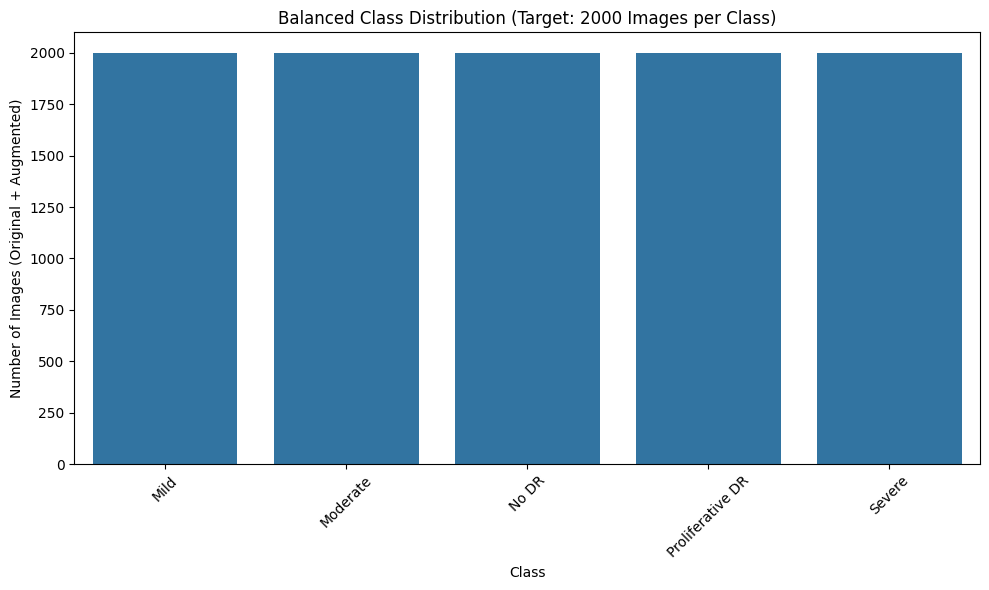

In [5]:
# Analyze the dataset and prepare for balanced sampling
balanced_dataset = {}
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    all_files = os.listdir(class_path)
    
    if len(all_files) >= TARGET_IMAGES_PER_CLASS:
        balanced_dataset[cls] = {
            'original_files': random.sample(all_files, TARGET_IMAGES_PER_CLASS),
            'needs_augmentation': False
        }
        print(f"Class {cls}: Sampled {TARGET_IMAGES_PER_CLASS} from {len(all_files)} original images")
    else:
        balanced_dataset[cls] = {
            'original_files': all_files,
            'needs_augmentation': True
        }
        print(f"Class {cls}: Using all {len(all_files)} original images + will generate {TARGET_IMAGES_PER_CLASS - len(all_files)} augmented images")

# Plot the balanced class distribution
plt.figure(figsize=(10, 6))
balanced_counts = [TARGET_IMAGES_PER_CLASS for _ in classes]
sns.barplot(x=classes, y=balanced_counts)
plt.title(f'Balanced Class Distribution (Target: {TARGET_IMAGES_PER_CLASS} Images per Class)')
plt.xlabel('Class')
plt.ylabel('Number of Images (Original + Augmented)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Step 3: Image Visualization


Step 3: Sample Image Visualization (from balanced dataset)


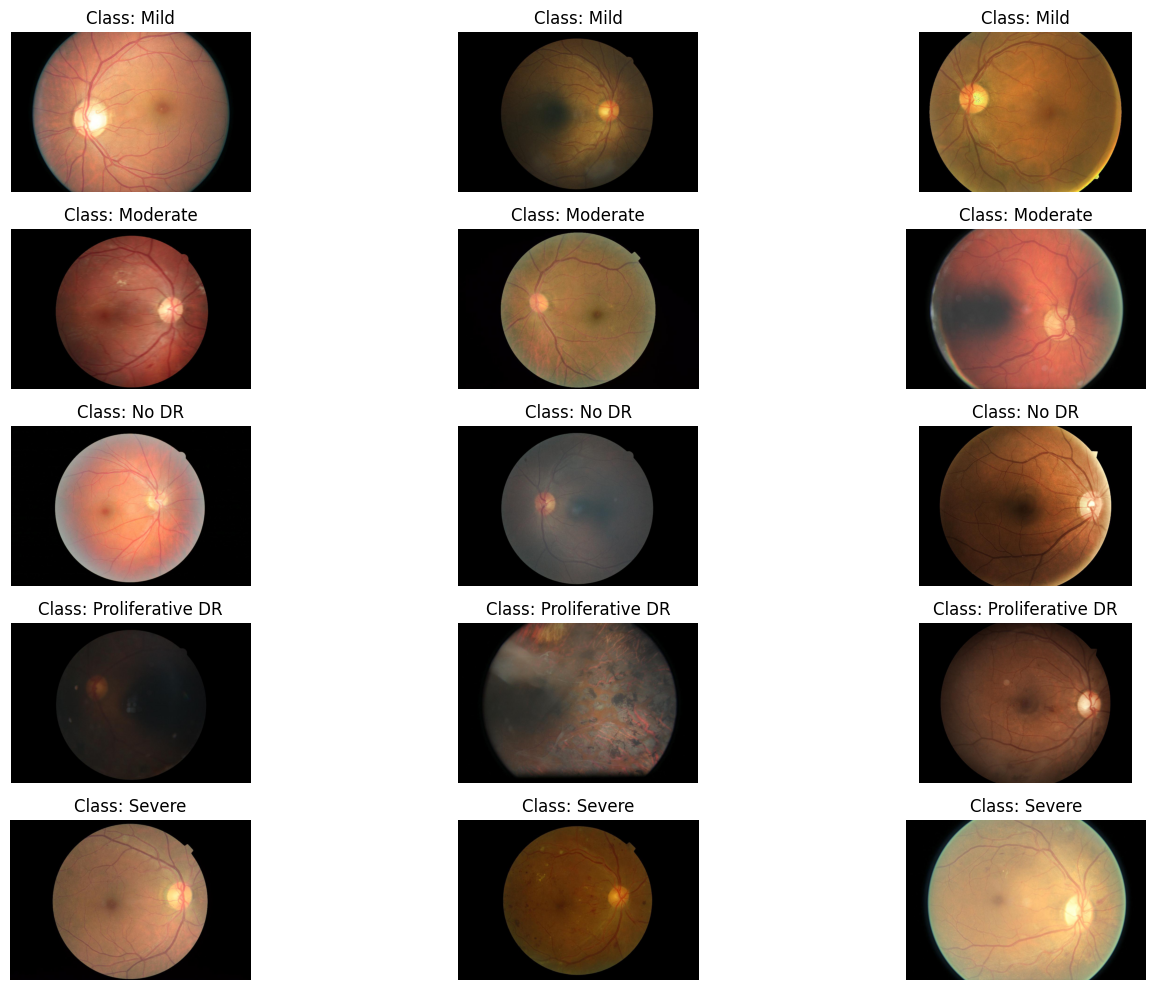

In [6]:
print("\nStep 3: Sample Image Visualization (from balanced dataset)")

def display_sample_images(classes, dataset_path, num_samples=3):
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        all_files = os.listdir(class_path)
        image_files = random.sample(all_files, min(num_samples, len(all_files)))
        
        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"Class: {cls}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(classes, dataset_path)

## Step 4: Data Preprocessing

Load and preprocess our balanced dataset for model training.

In [7]:
print("\nStep 4: Data Preprocessing with Balanced Dataset")

def load_and_preprocess_balanced_data(dataset_path, balanced_dataset, img_width, img_height, classes, test_size=0.2, val_size=0.1):
    X = []
    y = []
    
    class_to_label = {cls: i for i, cls in enumerate(classes)}
    
    for cls in tqdm(classes, desc="Processing classes"):
        class_path = os.path.join(dataset_path, cls)
        class_label = class_to_label[cls]
        
        if balanced_dataset[cls]['needs_augmentation']:
            class_images = augment_class(
                class_path, 
                balanced_dataset[cls]['original_files'], 
                TARGET_IMAGES_PER_CLASS
            )
            
            for img in tqdm(class_images, desc=f"Processing {cls} images", leave=False):
                try:
                    img_processed = preprocess_input(img)
                    X.append(img_processed)
                    y.append(class_label)
                except Exception as e:
                    print(f"Error processing image: {e}")
        else:
            for img_file in tqdm(balanced_dataset[cls]['original_files'], desc=f"Processing {cls} images", leave=False):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_width, img_height))
                    img_processed = preprocess_input(img)
                    
                    X.append(img_processed)
                    y.append(class_label)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42, stratify=y_train_val)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, class_to_label


Step 4: Data Preprocessing with Balanced Dataset


In [8]:
print("Loading and preprocessing the balanced dataset...")
X_train, X_val, X_test, y_train, y_val, y_test, class_to_label = load_and_preprocess_balanced_data(
    dataset_path, balanced_dataset, IMG_WIDTH, IMG_HEIGHT, classes)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Loading and preprocessing the balanced dataset...


Processing classes:  60%|██████    | 3/5 [03:19<02:14, 67.04s/it]

  Class has 708 images, generating 1292 augmented images


Loading original images: 100%|██████████| 708/708 [00:23<00:00, 30.56it/s]

Generating augmented images: 50it [00:21,  2.27it/s]
Generating augmented images: 50it [00:21,  2.27it/s]
Processing classes:  80%|████████  | 4/5 [04:05<00:59, 59.12s/it]

  Class has 873 images, generating 1127 augmented images


Loading original images: 100%|██████████| 873/873 [00:29<00:00, 29.87it/s]

Generating augmented images: 44it [00:20,  2.13it/s]

Processing classes: 100%|██████████| 5/5 [04:57<00:00, 59.55s/it]


X_train shape: (7000, 224, 224, 3)
X_val shape: (1000, 224, 224, 3)
X_test shape: (2000, 224, 224, 3)


In [9]:
print("\nSetting up data augmentation for training...")
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


Setting up data augmentation for training...


## Step 5: Model Building

We'll use EfficientNetB0 as our base model with transfer learning.

In [10]:
print("\nStep 5: Model Building")

def build_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5, name='top_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), len(classes))
model.summary()


Step 5: Model Building
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,061,096 (15.49 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

## Step 6: Model Training

Note: For TensorFlow 2.x with newer Keras versions, we need to use the '.keras' extension for model files instead of '.h5'

In [13]:
print("\nStep 6: Model Training")

# Determine the proper model file extension based on TF version
import tensorflow as tf
if tf.__version__.startswith('2') and int(tf.__version__.split('.')[1]) >= 10:
    # For newer TF versions that require .keras extension
    model_extension = '.keras'
    print("Using .keras extension for model saving (TensorFlow 2.10+)")
else:
    # For older TF versions that use .h5 extension
    model_extension = '.h5'
    print("Using .h5 extension for model saving (TensorFlow < 2.10)")

model_path = f'best_model{model_extension}'
export_model_path = f'dr_efficientnet_model_balanced{model_extension}'

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

batch_size = 32
epochs = 50

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Step 6: Model Training
Using .keras extension for model saving (TensorFlow 2.10+)
Epoch 1/50
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.3040 - loss: 2.0684
Epoch 1: val_accuracy improved from -inf to 0.34600, saving model to best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.34600, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3042 - loss: 2.0675 - val_accuracy: 0.3460 - val_loss: 1.4895 - learning_rate: 0.0010
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3042 - loss: 2.0675 - val_accuracy: 0.3460 - val_loss: 1.4895 - learning_rate: 0.0010
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.3909 - loss: 1.5801
Epoch 2: val_accuracy improved from 0.34600 to 0.35400, saving model to best_model.keras

Epoch 2: val_accuracy improved from 0.34600 to 0.35400, saving model to best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 206s 926ms/step - accuracy: 0.3909 - loss: 1.5800 - va

## Step 7: Model Evaluation


Step 7: Model Evaluation


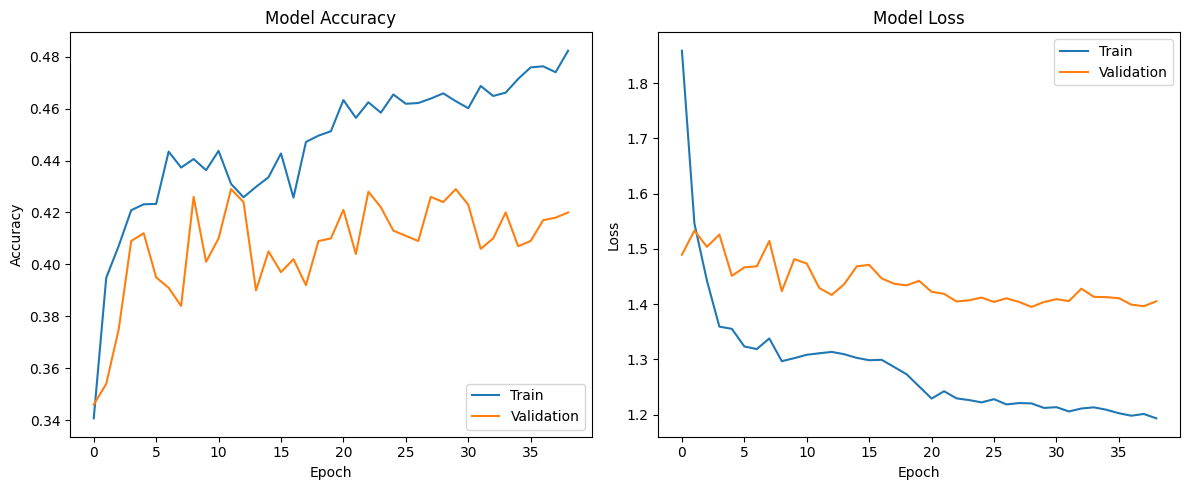

In [14]:
print("\nStep 7: Model Evaluation")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 846ms/step - accuracy: 0.4374 - loss: 1.3886
Test Accuracy: 0.4360
Test Loss: 1.3703


63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step


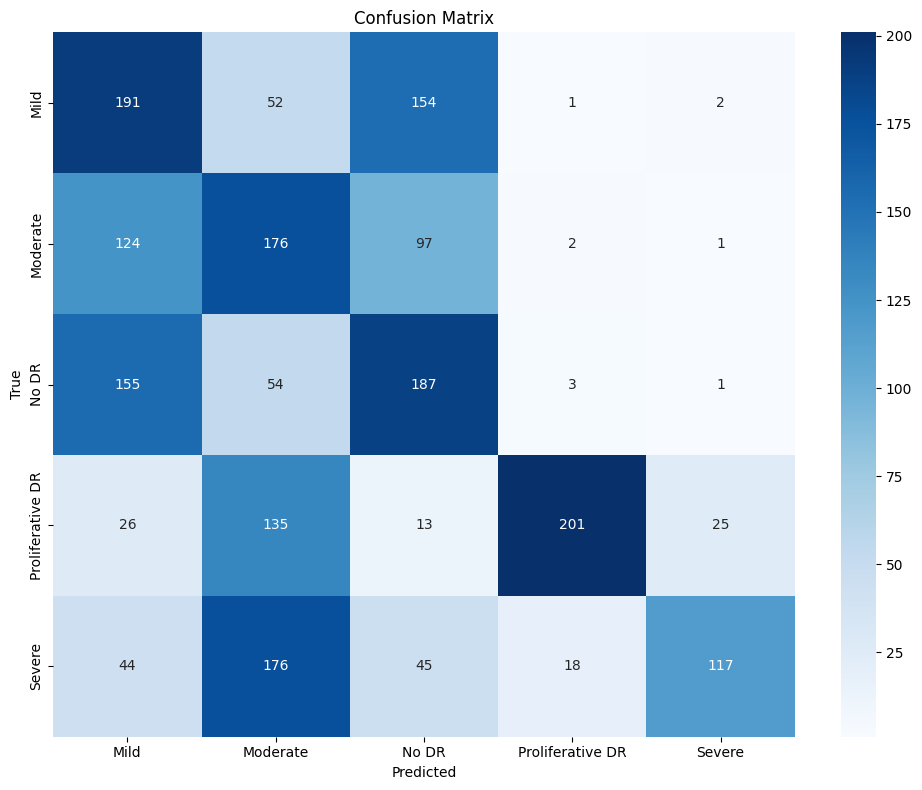

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [17]:
label_to_class = {v: k for k, v in class_to_label.items()}
target_names = [label_to_class[i] for i in range(len(classes))]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))


Classification Report:
                  precision    recall  f1-score   support

            Mild       0.35      0.48      0.41       400
        Moderate       0.30      0.44      0.35       400
           No DR       0.38      0.47      0.42       400
Proliferative DR       0.89      0.50      0.64       400
          Severe       0.80      0.29      0.43       400

        accuracy                           0.44      2000
       macro avg       0.54      0.44      0.45      2000
    weighted avg       0.54      0.44      0.45      2000



## Step 8: Visualize Predictions

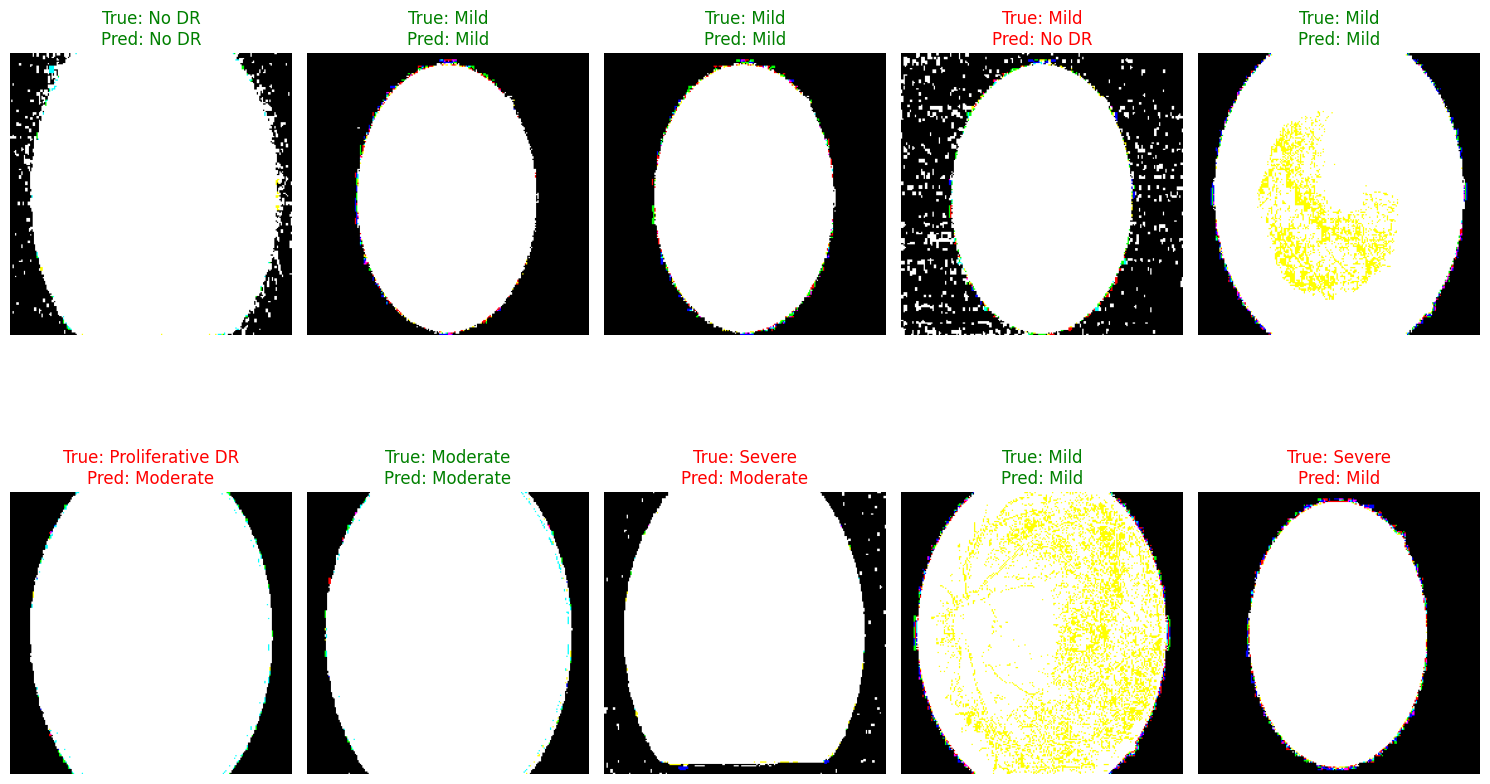

In [18]:
def display_predictions(X, y_true, y_pred, classes, num_samples=10):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        
        plt.subplot(2, 5, i+1)
        # For visualization, convert preprocessed image back to display format
        # This is a simplistic approach - adjust based on your preprocessing
        img_display = np.clip(img, 0, 1)
        plt.imshow(img_display)
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_predictions(X_test, y_test, y_pred_classes, classes)

## Step 9: Save the Model

In [ ]:
print("\nStep 9: Save the Model")
try:
    model.save(export_model_path)
    print(f"Model saved successfully as {export_model_path}")
except Exception as e:
    print(f"Error saving model: {e}")
    # Alternative saving method
    print("Trying alternative saving method...")
    try:
        model.save_weights(f"dr_model_weights{model_extension}")
        print(f"Model weights saved successfully as dr_model_weights{model_extension}")
    except Exception as e2:
        print(f"Error saving model weights: {e2}")

## Step 10: Function for Making Predictions on New Images

In [ ]:
def predict_new_image(image_path, model, class_labels, img_width=224, img_height=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img_array = np.expand_dims(img, axis=0)
    img_processed = preprocess_input(img_array)
    
    prediction = model.predict(img_processed)
    pred_class_idx = np.argmax(prediction)
    label_to_class = {v: k for k, v in class_to_label.items()}
    class_names_list = [label_to_class[i] for i in range(len(label_to_class))]
    pred_class = class_names_list[pred_class_idx]
    confidence = prediction[0][pred_class_idx]
    
    return pred_class, confidence

print("\nNote: You can use the predict_new_image function to make predictions on new images.")
print("Example usage:")
print("pred_class, confidence = predict_new_image('path_to_image.jpg', model, classes)")
print("print(f'Predicted class: {pred_class} with confidence: {confidence:.2f}')")